In [76]:
import pandas as pd
# read the data first
data = pd.read_csv('./data.csv')

In [77]:
col = data.columns
data.drop(['Unnamed: 32', 'id'], axis=1, inplace=True)
data = data.dropna()
# data.shape
data['label'] = data['diagnosis'].map({'M': 1, 'B': 0}) # prepare the binary label
data.drop(['diagnosis'], axis=1, inplace=True)

# Prepare the training set, validation set and testing set, ratio as 6:2:2

In [78]:
from sklearn.model_selection import train_test_split
random_seed = 888
data_train, data_rest = train_test_split(data, test_size=0.4, random_state=random_seed, stratify=data['label'])
data_test, data_validate = train_test_split(data_rest, test_size=0.5, random_state=random_seed, stratify=data_rest['label']) 

# Normalization of three sets

In [79]:
from sklearn.preprocessing import MinMaxScaler
def get_features_and_target_arrays(input_df):
    y = input_df['label']
    x = input_df.drop(['label'], axis=1)
    scaler = MinMaxScaler()
    x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index)
    return x_scaled, y

In [80]:
X_train, y_train = get_features_and_target_arrays(data_train)
X_test, y_test = get_features_and_target_arrays(data_test)
X_validate, y_validate = get_features_and_target_arrays(data_validate)

# Logistic regression

## Find the optimal hyperparameter C using the validation data with grid search

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define logistic regression model
logistic_reg = LogisticRegression(solver='liblinear') # liblinear is better for data of small size

# Define hyperparameters grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 1e5, 1e6, 1e7, 1e10]}  # 'C' is the inverse of lambda

# Create grid search object, using accuracy
grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_validate, y_validate)

# Get the best hyperparameter
best_hyperparameter = grid_search.best_params_['C']

print("Best hyperparameter:", best_hyperparameter)

Best hyperparameter: 1000


## Visualize the grid search for optimal hyperparameter

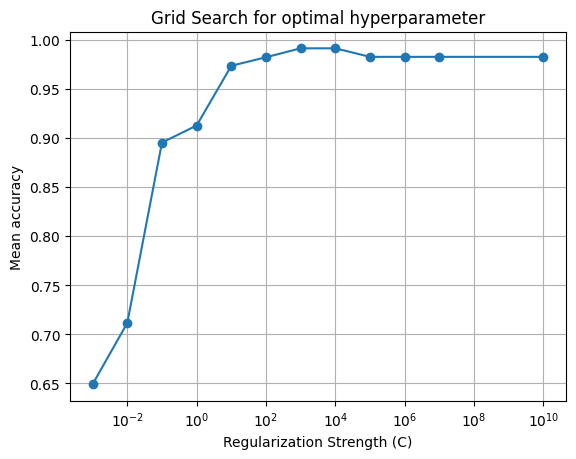

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Extract grid search results
results = grid_search.cv_results_
mean_test_scores = np.array(results['mean_test_score']).reshape(12, 1)

# Create a basic plot
plt.plot([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 1e5, 1e6, 1e7, 1e10], mean_test_scores, marker='o')
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Mean accuracy')
plt.title('Grid Search for optimal hyperparameter')
plt.grid(True)
plt.show()

## Train the model using the best hyperparameter learnt

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Initialize logistic regression model with the optimal hyperparameter value
logistic_reg = LogisticRegression(solver='liblinear', C=best_hyperparameter, penalty='l2')

# Train the model on the entire training dataset
logistic_reg.fit(X_train, y_train)
# Calculate training accuracy
training_accuracy = accuracy_score(y_train, y_train)
print("Training Accuracy:", training_accuracy)

# Predict the labels on the test dataset
y_pred_test = logistic_reg.predict(X_test)
# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_test)
# Print accuracy
print("Accuracy:", accuracy)

Training Accuracy: 1.0
Accuracy: 0.9122807017543859


## prepare the plot data of Logistic regression 

In [84]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Get predicted probabilities for positive class
y_pred_prob_logistic = logistic_reg.predict_proba(X_test)[:, 1]

# Compute precision and recall
precision_logistic, recall_logistic, thresholds_logistic  = precision_recall_curve(y_test, y_pred_prob_logistic)

# Compute F1 score
f1_logistic = 2 * (precision_logistic * recall_logistic) / (precision_logistic + recall_logistic)

# Compute ROC curve
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_prob_logistic)

# Compute area under the curves (AUC)
pr_auc_logistic = auc(recall_logistic, precision_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Deep learning method

In [85]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import os


In [86]:
print(type(y_train))
print(type(y_train.values))
x_data = Variable(torch.from_numpy(X_train.values))
y_data = Variable(torch.from_numpy(y_train.values))


X_validate = Variable(torch.from_numpy(X_validate.values))
y_validate = Variable(torch.from_numpy(y_validate.values))
print(type(y_validate))
print(type(X_validate))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [87]:
y_data.shape, x_data.numpy().shape

(torch.Size([341]), (341, 30))

In [88]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1 = torch.nn.Linear(30,16)
        self.l2 = torch.nn.Linear(16,4)
        self.l3 = torch.nn.Linear(4,1)
        self.dropout1 = torch.nn.Dropout(p=0.2)
        self.dropout2 = torch.nn.Dropout(p=0.2)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        out1 = self.sigmoid(self.l1(x)) 
        k=self.dropout1(out1)
        out2 = self.sigmoid(self.l2(k))
        j=self.dropout2(out2)
        y_pred = self.sigmoid(self.l3(j))
        return y_pred
    
model = Model()

In [89]:
x_data.float().size(), y_data.float().size()

(torch.Size([341, 30]), torch.Size([341]))

In [90]:
def create_and_train_model(learning_rate, weight_decay, num_epochs, x_data, y_data):
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.BCELoss()
    losses = []
    accuracies = []  # Store accuracies for each epoch
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_data.float())  # Convert input to float type
        loss = criterion(y_pred, y_data.view(-1, 1).float())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        # Evaluation loop
        model.eval()
        with torch.no_grad():
            y_pred = model(x_data.float())  # Convert input to float type
            y_pred_class = (y_pred >= 0.5).float()
            accuracy = (y_pred_class == y_data.view(-1, 1).float()).float().mean().item()
            accuracies.append(accuracy)
        
    return model, losses, accuracies

In [91]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [0.001],
    'weight_decay': [1e-3],
    'num_epochs': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500]
}

best_val_loss = float('inf')
best_hyperparameters = None
best_accuracies = None


# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    model, losses, accuracies = create_and_train_model(
        params['learning_rate'], params['weight_decay'], params['num_epochs'],
        X_validate,
        y_validate
    )
    if losses[-1] < best_val_loss:
        best_val_loss = losses[-1]
        best_hyperparameters = params
        best_accuracies = accuracies
        
        

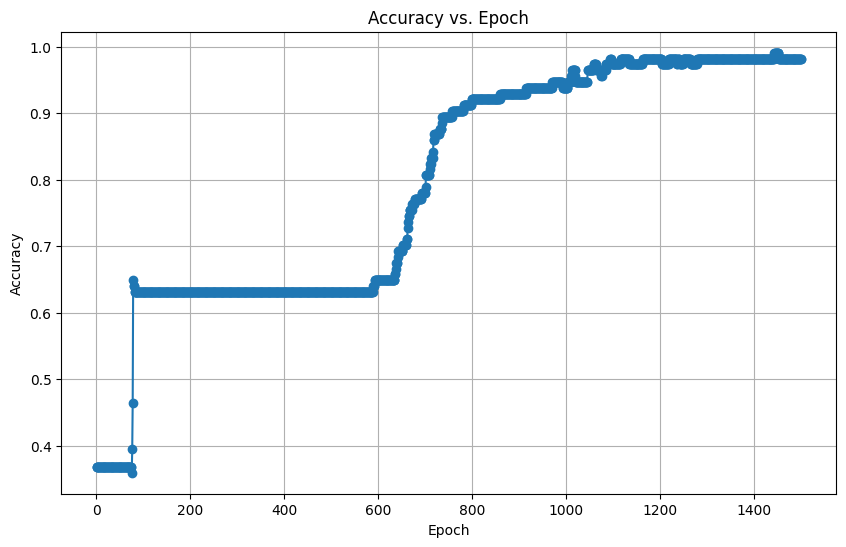

In [92]:
import matplotlib.pyplot as plt

# Plot accuracy for each epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_accuracies) + 1), best_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.grid(True)
plt.show()

In [93]:
criterion = torch.nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)
losses=[]
for epochs in range(600):
    y_pred = model(x_data.float())
    loss = criterion(y_pred, y_data.view(-1,1).float())
#     print('Epoch',epochs,'Loss:',loss.item(), '- Pred:', y_pred.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss)

In [94]:
x_data.data[0]

tensor([0.0379, 0.2537, 0.0514, 0.0188, 0.3907, 0.3218, 0.2170, 0.1147, 0.0555,
        0.4732, 0.0730, 0.1929, 0.1183, 0.0187, 0.7590, 0.6275, 0.2339, 0.4372,
        0.2245, 0.1605, 0.0191, 0.1346, 0.0387, 0.0100, 0.3071, 0.2028, 0.1233,
        0.1341, 0.0207, 0.2371], dtype=torch.float64)

In [95]:
model.double().forward(x_data.data[25]) > 0.5, y_data[25]

(tensor([True]), tensor(1))

In [96]:
model.double().forward(x_data.data[55]) > 0.5, y_data[55]

(tensor([False]), tensor(0))

In [97]:
pred = model.double().forward(x_data) > 0.5
pred.numpy()

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [

In [98]:
a = pred.numpy()
b = y_data.numpy()
pred.numpy().reshape(-1).shape, y_data.numpy().shape

((341,), (341,))

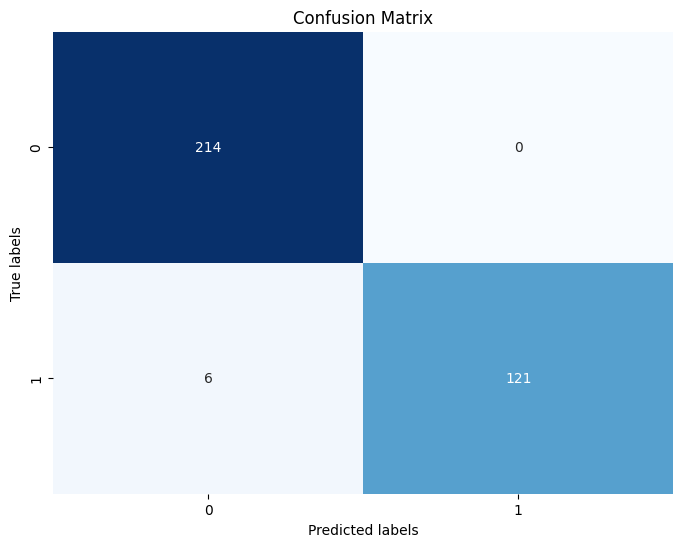

In [99]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(b, a)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

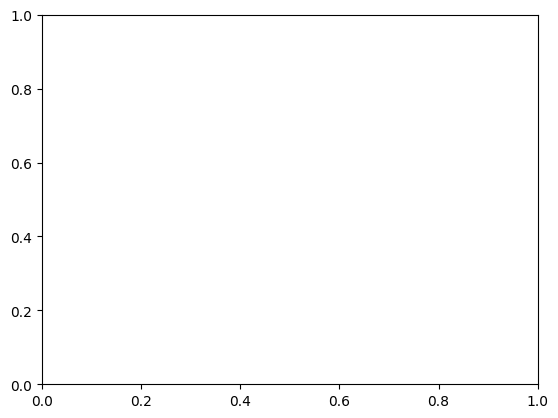

In [100]:
plt.plot(range(1, 600 + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

In [101]:
from sklearn.metrics import accuracy_score

X_test = torch.from_numpy(np.array(X_test))
y_test = torch.from_numpy(np.array(y_test))

threshold = 0.5

y_pred_test = model.double().forward(X_test).detach().numpy()
y_pred_test = [0 if pred < threshold else 1 for pred in y_pred_test]
y_pred_test=torch.from_numpy(np.array(y_pred_test))

# print(y_test)
# print(y_pred_test)
# print(type(y_test))
# print(type(y_pred_test))
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)

Accuracy: 0.956140350877193


## prepare the plotting data 

In [102]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Make predictions
with torch.no_grad():
    pred_test_2 = model.double().forward(X_test).detach().numpy()

# Compute ROC curve and ROC area
fpr_2, tpr_2, thresholds_roc_2 = roc_curve(y_test.numpy(), pred_test_2)

# Ensure FPR and TPR have the same shape as thresholds
print("Shape of FPR:", fpr_2.shape)
print("Shape of TPR:", tpr_2.shape)
print("Shape of thresholds_roc:", thresholds_roc_2.shape)

roc_auc_2 = auc(fpr_2, tpr_2)

# Compute precision-recall curve and area under the curve
precision_2, recall_2, _ = precision_recall_curve(y_test.numpy(), pred_test_2)
pr_auc = auc(recall_2, precision_2)

Shape of FPR: (6,)
Shape of TPR: (6,)
Shape of thresholds_roc: (6,)


In [103]:

from sklearn.metrics import f1_score
thresholds = np.linspace(0, 1, 100)
f1_scores_2 = [f1_score(y_data.numpy(), (pred >= threshold).int()) for threshold in thresholds]


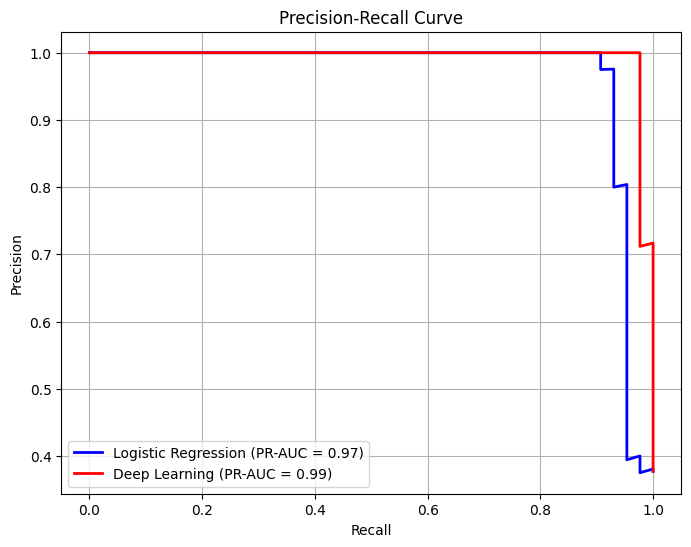

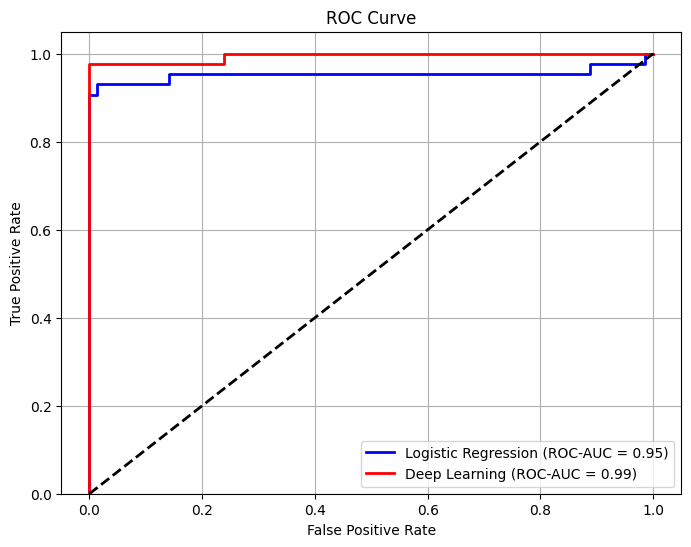

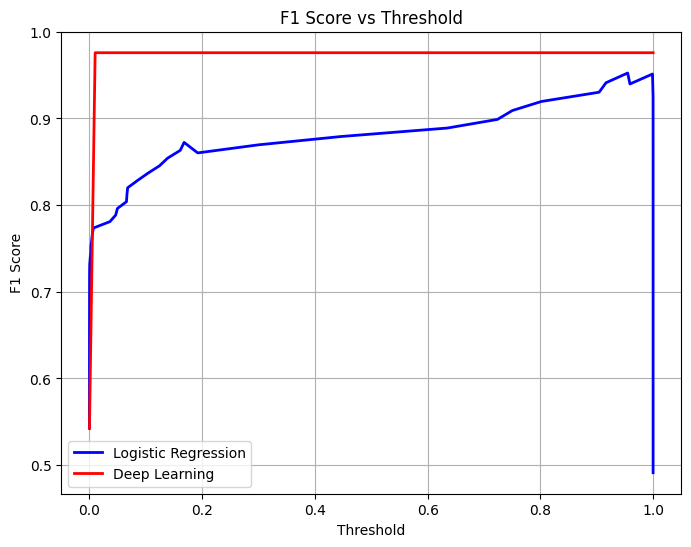

In [112]:
import matplotlib.pyplot as plt

# Plot Precision-Recall curves
plt.figure(figsize=(8, 6))

# Logistic Regression
plt.plot(recall_logistic, precision_logistic, color='blue', lw=2, label='Logistic Regression (PR-AUC = %0.2f)' % pr_auc_logistic)

# Deep Learning
plt.plot(recall_2, precision_2, color='red', lw=2, label='Deep Learning (PR-AUC = %0.2f)' % pr_auc)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Logistic Regression
plt.plot(fpr_logistic, tpr_logistic, color='blue', lw=2, label='Logistic Regression (ROC-AUC = %0.2f)' % roc_auc_logistic)

# Deep Learning
plt.plot(fpr_2, tpr_2, color='red', lw=2, label='Deep Learning (ROC-AUC = %0.2f)' % roc_auc_2)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 curves
plt.figure(figsize=(8, 6))

# Logistic Regression
plt.plot(thresholds_logistic, f1_logistic[:-1], color='blue', lw=2, label='Logistic Regression')

# Deep Learning
plt.plot(thresholds, f1_scores_2, color='red', lw=2, label='Deep Learning')

plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()
